# LSTM Implementation

In [127]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For time stamps
from datetime import datetime

In [128]:
df = pd.read_csv('./data/all_stocks_5yr.csv')

In [129]:
top_10_companies_names = ['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO']
BAC = df[df['Name']=='BAC'].reset_index(drop=True)
AAPL = df[df['Name']=='AAPL'].reset_index(drop=True)
GE = df[df['Name']=='GE'].reset_index(drop=True)
F = df[df['Name']=='F'].reset_index(drop=True)
FB = df[df['Name']=='FB'].reset_index(drop=True)
MSFT = df[df['Name']=='MSFT'].reset_index(drop=True)
AMD = df[df['Name']=='AMD'].reset_index(drop=True)
MU = df[df['Name']=='MU'].reset_index(drop=True)
INTC = df[df['Name']=='INTC'].reset_index(drop=True)
CSCO = df[df['Name']=='CSCO'].reset_index(drop=True)
top_10_companies = [BAC, AAPL, GE, F, FB, MSFT, AMD, MU, INTC, CSCO] 

In [130]:
for c in top_10_companies:
    c.index = pd.to_datetime(c['date'])
    c.drop(columns=['Name'],inplace=True)

## Scaling Data

In [131]:
series = MSFT

In [132]:
from sklearn.preprocessing import MinMaxScaler

In [133]:
training_size = int(len(series)*.8)
train_data =  series[:training_size]
test_data  = series[training_size:]

In [134]:
import math

def get_x_y(series, lag_n):
    close_prices = series['close']
    values = close_prices.values
    training_data_len = math.ceil(len(values)* 0.8)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(values.reshape(-1,1))
    train_data = scaled_data[0: training_data_len, :]

    x_train = []
    y_train = []

    for i in range(lag_n, len(train_data)):
        x_train.append(train_data[i-lag_n:i, 0])
        y_train.append(train_data[i+offset, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    test_data = scaled_data[training_data_len-lag_n: , : ]
    x_test = []
    y_test = values[training_data_len:]

    for i in range(lag_n, len(test_data)):
        x_test.append(test_data[i-lag_n:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_train,y_train,x_test,y_test,scaler

## Build Model

In [135]:
import keras
from keras import layers

model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_13 (LSTM)              (None, 100)               80400     
                                                                 
 dense_12 (Dense)            (None, 25)                2525      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [136]:
model.compile(optimizer='adam', loss='mean_squared_error')
x_train, y_train, _, _,_= get_x_y(series,60)
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
948/948 [==============================] - 38s 36ms/step - loss: 0.0011
Epoch 2/3
948/948 [==============================] - 36s 37ms/step - loss: 4.4810e-04
Epoch 3/3
948/948 [==============================] - 31s 32ms/step - loss: 3.5758e-04


array([[0.08438002],
       [0.08351223]], dtype=float32)

## Apply Model to new stock

In [153]:
test_s=AAPL

In [154]:

_,_,x_test,y_test,scaler = get_x_y(test_s,60)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
# rmse = np.sqrt(np.mean(predictions - y_test)**2)
# print(rmse)

/tmp/ipykernel_21711/207481894.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['predictions'] = predictions


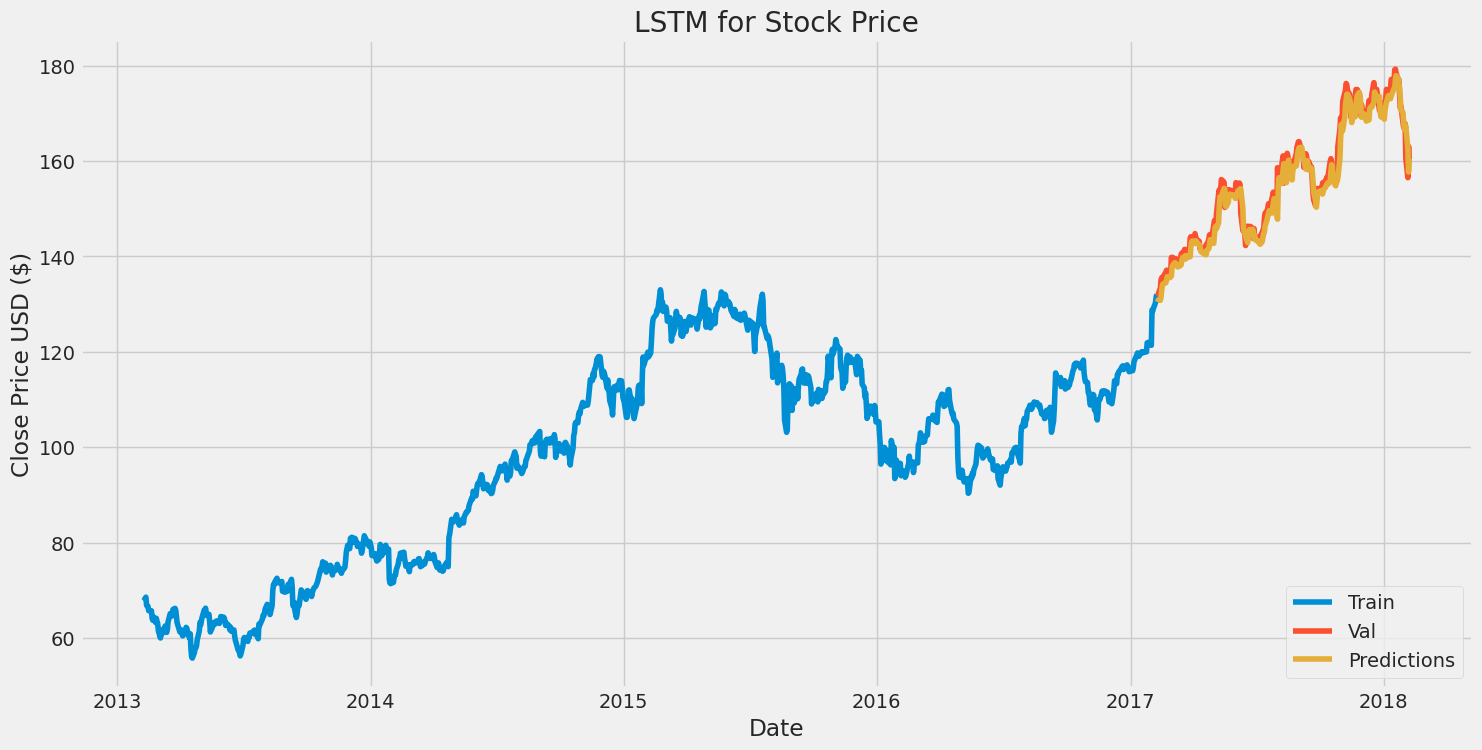

In [155]:
data = test_s.filter(['close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('LSTM for Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['close', 'predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()